# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abstract_udmis import AbstractUDMIS
import time

# https://networkx.org/documentation/stable/index.html
from networkx.algorithms.approximation import independent_set

# https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#independent_vertex_sets
import igraph

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
#         print("num_vertices:",self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for k in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)

            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)): # Set the condition for acception or rejection
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0
        return current_energy

In [3]:
def run_annealing(udmis, N=5000, T_i=100, T_f=0.01,verbose=False, 
                  plot_annealing=True, plot_occupation=True, annotate=False):

#     N = 5000
    t = np.arange(N+1)
#     T_i = 100
#     T_f = 0.01

    T = T_i * ((T_f/T_i) ** (t/N))

    temp_ = []
    E_ = []
    tik = time.time()
    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = T[t]
        temp_.append(temp)
        E = udmis.mc_step(T=temp)
        E_.append(E)
        if verbose and t % 300 == 0:
            print(t, E)
    tok = time.time()
    if plot_annealing:
        fig=plt.figure(figsize = (12,3))
        ax = fig.add_subplot(121)
        plt.plot(temp_, E_)
        plt.xscale('log')
        ax.invert_xaxis()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Energy')
        plt.title('Simulated Annealing (Run time: {:0.5f} sec)\nNumber of annealing steps: {:d}\nu={:0.2f}, T_i={:0.1f}K, T_f={:0.2f}K'.format(tok-tik, N, udmis.u, T_i, T_f))
    
    
    if plot_occupation:
        occupation = udmis.occupations
        ax = fig.add_subplot(122, aspect =1)
        for i in range(len(graph)):
            x,y = graph[i]
            circle = plt.Circle((x,y), 0.5, alpha = 0.9 if occupation[i] else 0.1,
                                facecolor='r' if occupation[i] else 'b',fill=True)
            ax.add_patch(circle)
            if annotate:
                plt.text(x,y, i+1, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),sum(occupation)))
        ax.autoscale()
        plt.show()
    
    return sum(occupation), tok-tik, temp_, E_

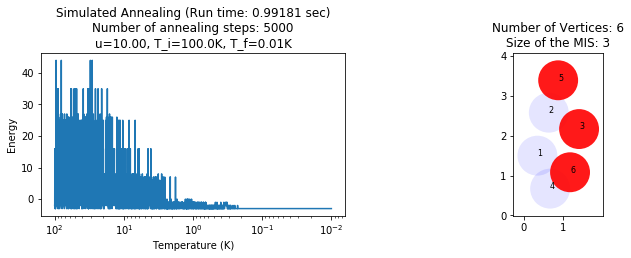

In [4]:
u = 10
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis, annotate=True);

## More complex graphs

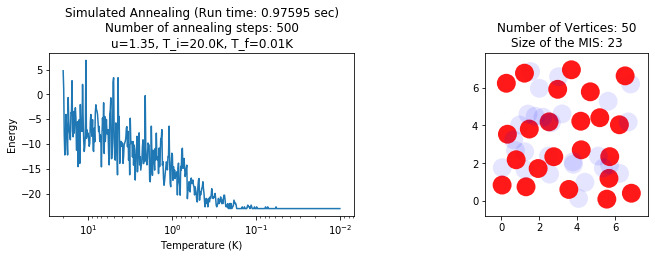

In [70]:
u = 1.35
num_vertices = 50
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, annotate=False,N=500, T_i=20, T_f=0.01);

## Varying the number of steps, i.e. cooling speed

Set u = 1.35

In [6]:
# Create a graph used for all the following programs
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)

num_steps = []
run_times = []
MIS_sizes = []

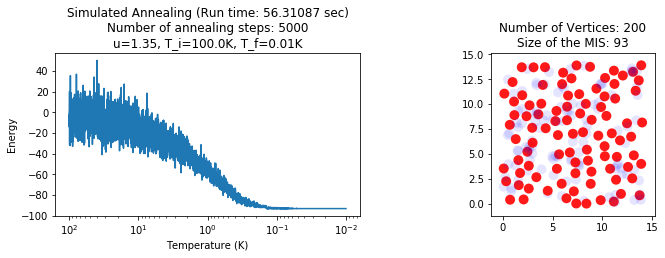

In [7]:
N = 5000
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

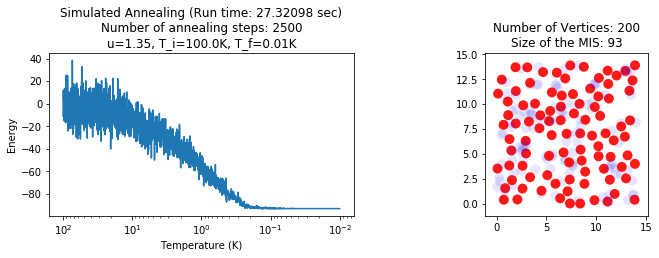

In [8]:
N = 2500
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

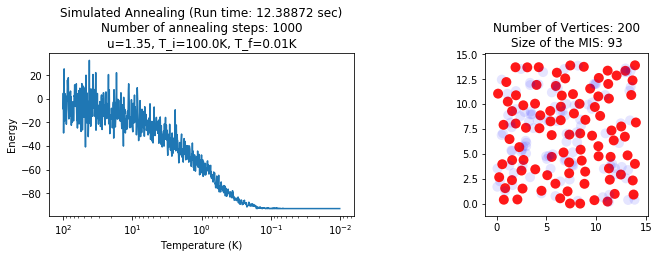

In [9]:
N = 1000
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

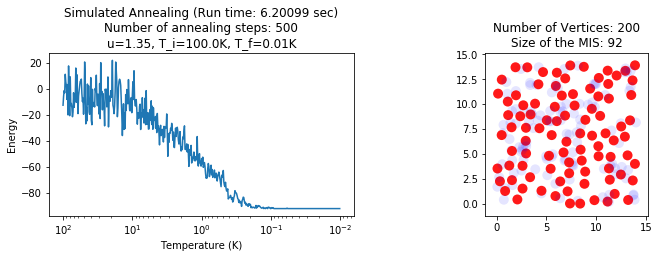

In [10]:
N = 500
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

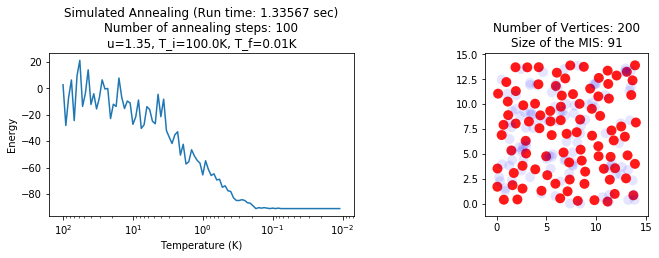

In [11]:
N = 100
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

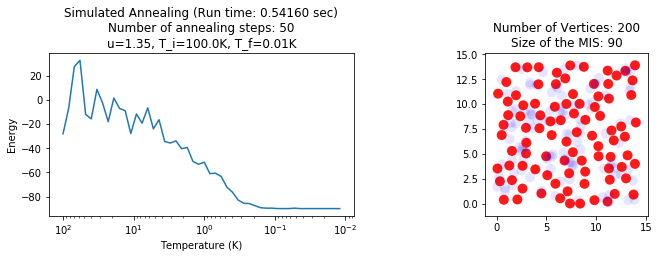

In [12]:
N = 50
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

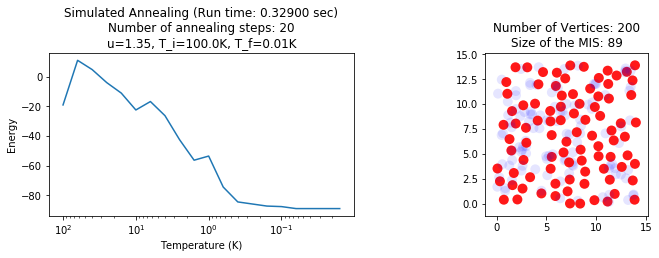

In [13]:
N = 20
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

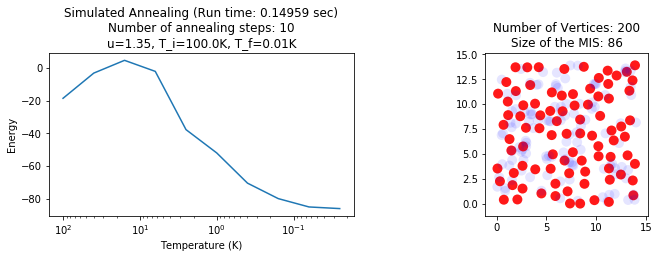

In [14]:
N = 10
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

In [15]:
num_steps1 = num_steps
run_times1 = run_times
MIS_sizes1 = MIS_sizes

Set u = 100, and do the same study

In [16]:
# Create a graph used for all the following programs
u = 100
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)

num_steps = []
run_times = []
MIS_sizes = []

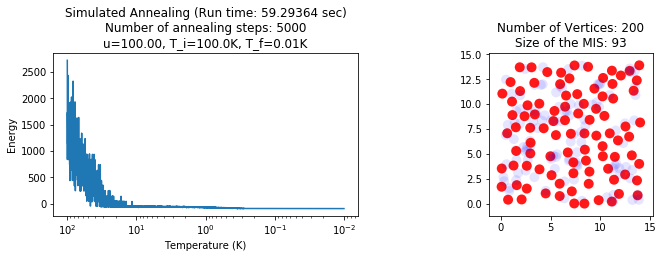

In [17]:
N = 5000
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

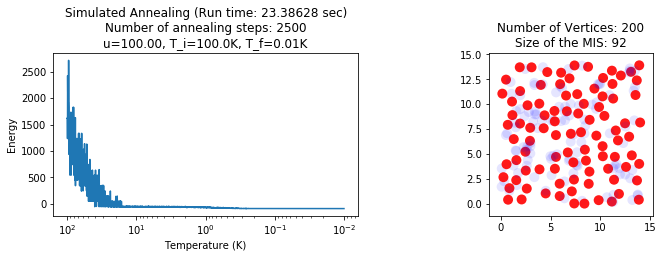

In [18]:
N = 2500
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

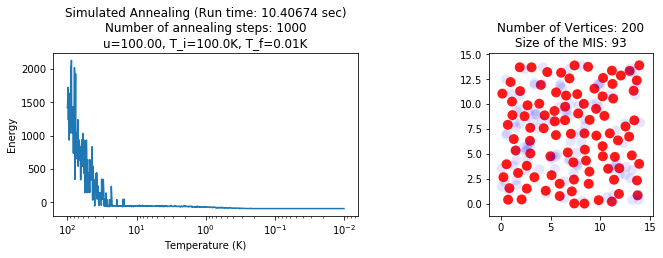

In [19]:
N = 1000
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

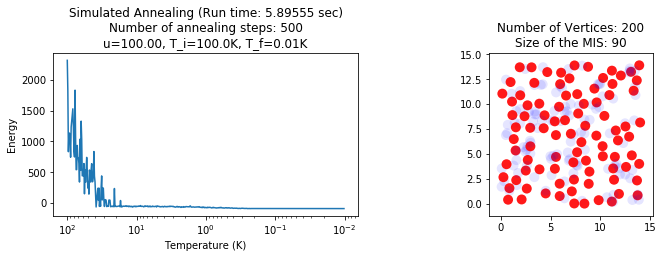

In [20]:
N = 500
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

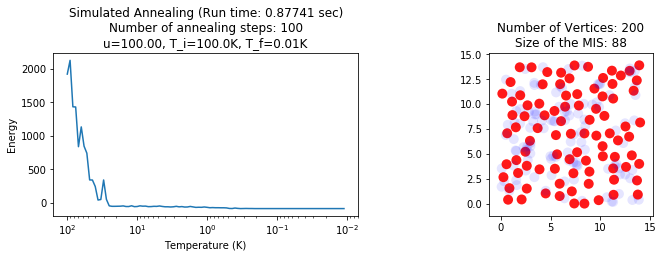

In [21]:
N = 100
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

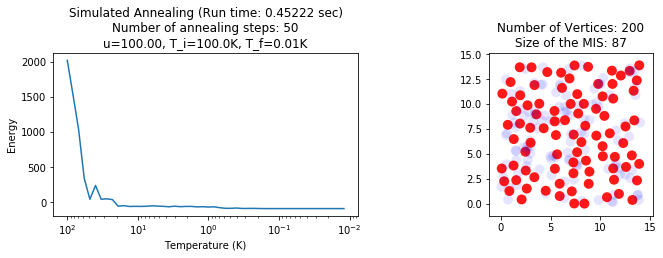

In [22]:
N = 50
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

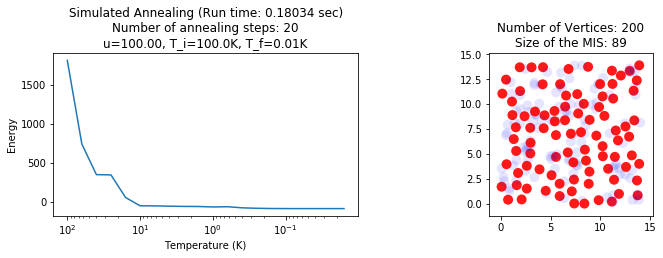

In [23]:
N = 20
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

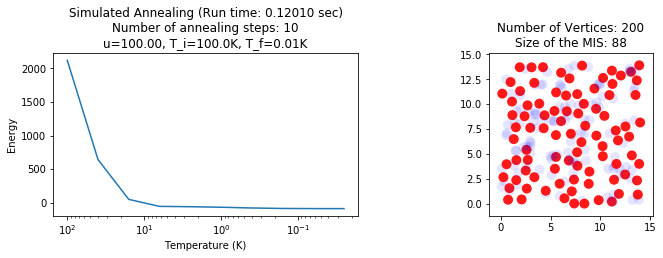

In [24]:
N = 10
np.random.seed(100)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
num_steps.append(N)
run_times.append(run_time)
MIS_sizes.append(mis_size)

In [25]:
num_steps2 = num_steps
run_times2 = run_times
MIS_sizes2 = MIS_sizes

#### Plot the performance as a function of number of cooling steps

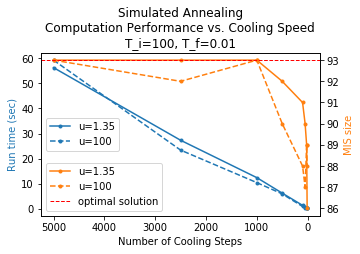

In [27]:
fig=plt.figure(figsize = (5,3))
ax1 = fig.add_subplot(111)
ax1.plot(num_steps1, run_times1,'.-',c='tab:blue', label = 'u=1.35')
ax1.plot(num_steps2, run_times2,'.--',c='tab:blue', label = 'u=100')
ax1.invert_xaxis()
ax1.legend(loc='center left')

ax2 = ax1.twinx()
ax2.plot(num_steps1, MIS_sizes1,'.-', c='tab:orange', label = 'u=1.35')
ax2.plot(num_steps2, MIS_sizes2,'.--',c='tab:orange', label = 'u=100')
ax2.axhline(y=93, color='r', linestyle='--', lw=1,label = 'optimal solution')
ax1.set_xlabel('Number of Cooling Steps')
ax1.set_ylabel('Run time (sec)', color='tab:blue')
ax2.set_ylabel('MIS size', color='tab:orange')
ax2.legend()
plt.title('Simulated Annealing\nComputation Performance vs. Cooling Speed\nT_i=100, T_f=0.01')
plt.savefig("cannealing_vary_steps.png", dpi=300, bbox_inches="tight")
plt.show()

## Varying the parameter u

In [28]:
# Create a graph used for all the following programs
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

N=2000
u_list = []
MIS_sizes = []
temp_s = []
E_s = []

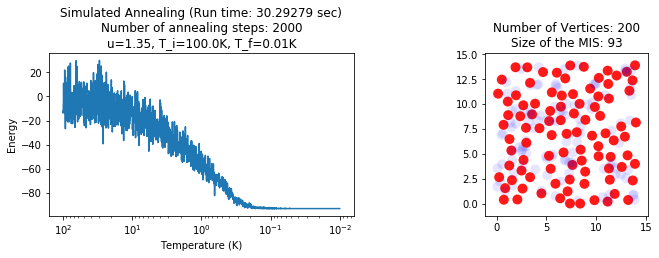

In [29]:
u = 1.35
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

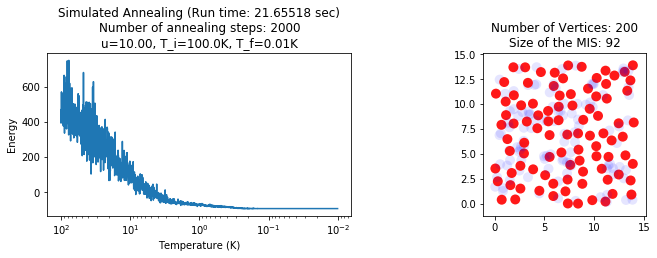

In [30]:
u = 10
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

The size of the MIS is not correct now. This indicates u is too large.

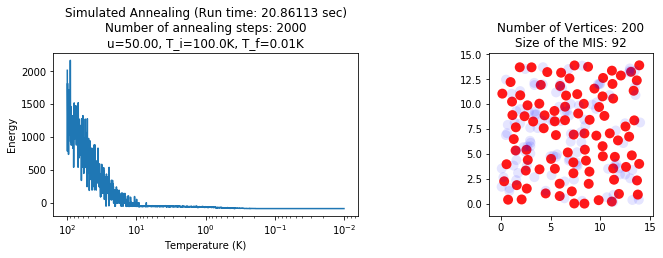

In [31]:
u = 50
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

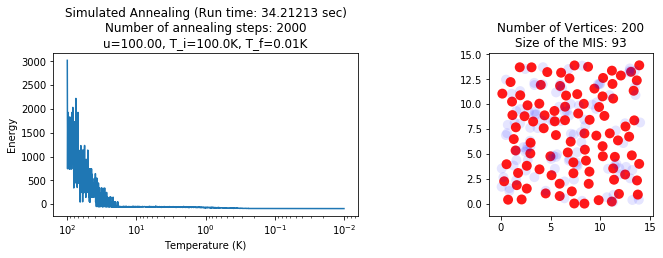

In [32]:
u = 100
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

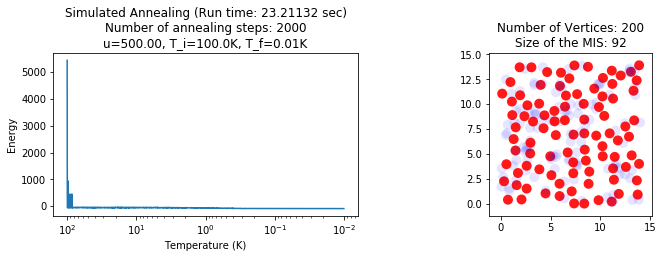

In [33]:
u = 500
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

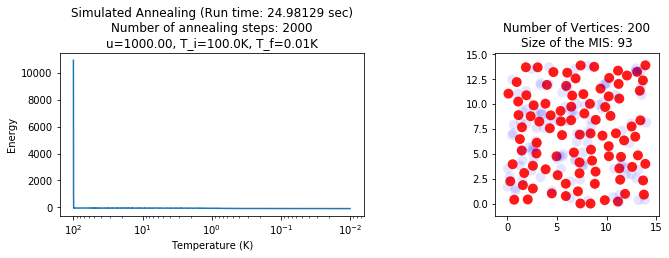

In [34]:
u = 1000
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

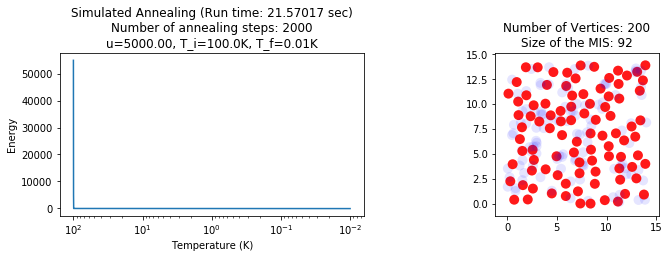

In [35]:
u = 5000
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

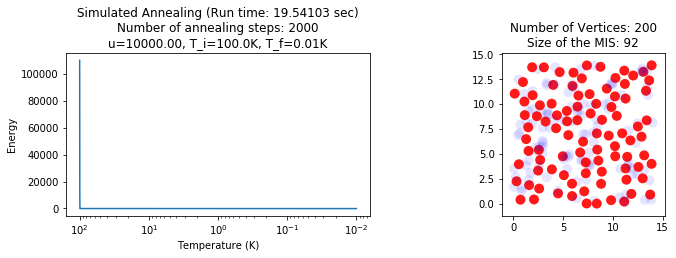

In [37]:
u = 10000
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

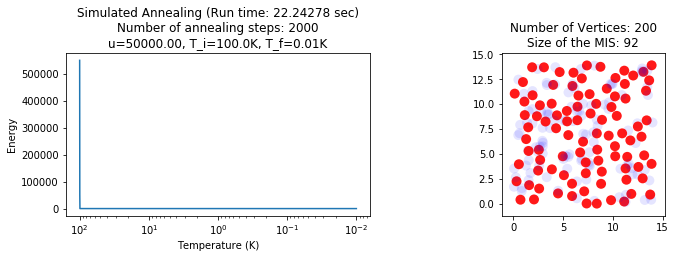

In [39]:
u = 50000
np.random.seed(100)
udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=N, T_i=100, T_f=0.01);
u_list.append(u)
MIS_sizes.append(mis_size)
temp_s.append(temp_)
E_s.append(E_)

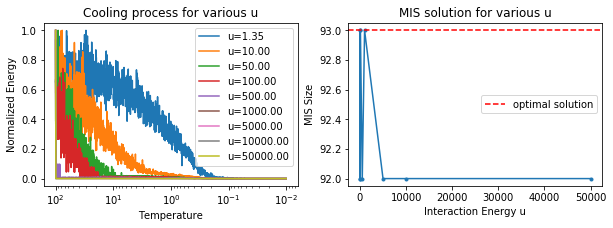

In [41]:
fig=plt.figure(figsize = (10,3))
ax1 = fig.add_subplot(121)
for i in range(len(E_s)):
    ax1.plot(temp_s[i], (E_s[i]-min(E_s[i]))/max(E_s[i]-min(E_s[i])), label='u={:.2f}'.format(u_list[i]))
plt.xscale('log')
ax1.invert_xaxis()
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Normalized Energy')
ax1.set_title('Cooling process for various u')
plt.legend()

ax2 = fig.add_subplot(122)
ax2.plot(u_list, MIS_sizes, '.-')
ax2.axhline(y=93, color='r', linestyle='--', label = 'optimal solution')
ax2.set_title('MIS solution for various u')
ax2.set_xlabel('Interaction Energy u')
ax2.set_ylabel('MIS Size')
plt.savefig("cannealing_vary_u.png", dpi=300, bbox_inches="tight")
plt.legend()
plt.show()

## Benchmark with other classical algorithms
### Approximate Solution by NetworkX

The approximate algorithm is based on the following paper: 
Boppana, R., & Halldórsson, M. M. (1992). Approximating maximum independent sets by excluding subgraphs. BIT Numerical Mathematics, 32(2), 180–196. Springer. doi:10.1007/BF01994876
https://link.springer.com/article/10.1007%2FBF01994876

Time Comlexity: O(|V|/(log|V|)$^2$), where |V| is the number of vertices.


In [42]:
import networkx as nx
def networkx_mis(graph, annotate=False):
    edges = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            dij = np.sqrt((graph[i][0] - graph[j][0])**2 + (graph[i][1] - graph[j][1])**2)
            if dij<=1:
                edges.append((i,j))
    G = nx.Graph()
    G.add_edges_from(edges)
    tik = time.time()
    MIS = independent_set.maximum_independent_set(G)
    tok = time.time()
    udmis = UDMIS(u, graph)

    fig=plt.figure(figsize = (6,3))
    ax = fig.add_subplot(121)
    nx.draw(G, with_labels=True, node_size=50, nodelist = G.nodes, alpha=1,
           node_color=['r' if i in MIS else 'b' for i in G.nodes])
    ax.set_title('Approximate Solution by NetworkX\nRun time: {:0.5f} sec'.format(tok-tik))
    ax = fig.add_subplot(122, aspect =1)

    for i in range(len(graph)):
        x,y = graph[i]
        circle = plt.Circle((x,y), 0.5, alpha = 0.9 if i in MIS else 0.1,
                                    facecolor='r' if i in MIS else 'b',fill=True)
        ax.add_patch(circle)
        if annotate:
            plt.text(x,y, i, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),len(MIS)))
        ax.autoscale()
    plt.show()
    return len(MIS), tok-tik, MIS

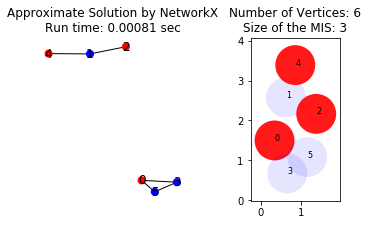

In [43]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
mis_size, run_time, mis = networkx_mis(graph, True)

#### More complex graphs

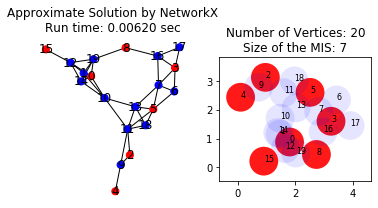

In [44]:
num_vertices = 20
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(300)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
mis_size, run_time, mis = networkx_mis(graph, True);

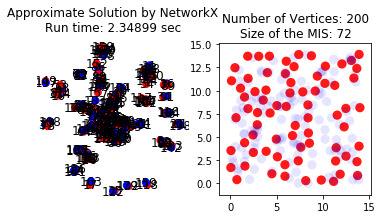

In [45]:
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
mis_size, run_time, mis = networkx_mis(graph);

### Exact Solution from iGraph
The exact algorithm is based on this paper: "The current implementation was ported to igraph from the Very Nauty Graph Library by Keith Briggs and uses the algorithm from the paper S. Tsukiyama, M. Ide, H. Ariyoshi and I. Shirawaka. A new algorithm for generating all the maximal independent sets. SIAM J Computing, 6:505–517, 1977".https://epubs.siam.org/doi/abs/10.1137/0206036?journalCode=smjcat

The processing time and memory space are bounded by $O(nm\mu)$ and $O(n+m)$, respectively, where n, m, and $\mu$ are the numbers of vertices, edges, and maximal independent sets of a graph.

In [46]:
def igraph_mis(graph, annotate=False):
    edges = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            dij = np.sqrt((graph[i][0] - graph[j][0])**2 + (graph[i][1] - graph[j][1])**2)
            if dij<=1:
                edges.append((i,j))
    
    g = igraph.Graph()
    g.add_vertices(len(graph))
    g.add_edges(edges)
    tik = time.time()
    MIS = g.largest_independent_vertex_sets()[0]
    tok = time.time()
    visual_style = {"vertex_label": [i for i in range(len(graph))], 
                    "vertex_size": 10,"bbox":(200, 200), "margin":20,
                   "vertex_color": ['red' if i in MIS else 'blue' for i in range(len(graph))]}
    fig=plt.figure(figsize = (6, 3))
    ax = fig.add_subplot(121)
    igraph.plot(g, **visual_style, target=ax)
    ax.set_title('Exact Solution by igraph\nRun time: {:0.5f}sec'.format(tok-tik))
    ax = fig.add_subplot(122, aspect =1)
    for i in range(len(graph)):
        x,y = graph[i]
        circle = plt.Circle((x,y), 0.5, alpha = 0.9 if i in MIS else 0.1,
                            facecolor='r' if i in MIS else 'b',fill=True)
        ax.add_patch(circle)
        if annotate:
            plt.text(x,y, i, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),len(MIS)))
        ax.autoscale()
    plt.show()
    return len(MIS), tok-tik, MIS

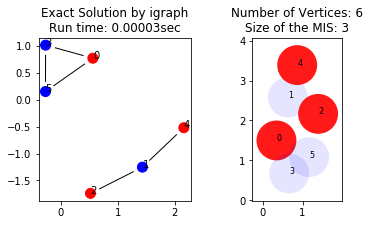

In [47]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
mis_size, run_time, mis = igraph_mis(graph, True)

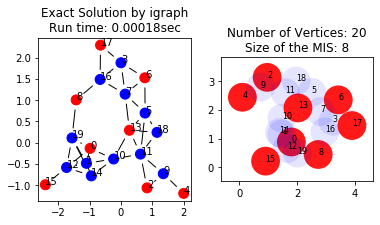

In [48]:
num_vertices = 20
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(300)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
mis_size, run_time, mis = igraph_mis(graph, True);

# Compare Performance Across Different Classical Algorithms

In [52]:
# num_vertices_list = [6,10,20,40,60,80]
num_vertices_list = []
run_time_annealing = []
run_time_networks = []
run_time_igraph = []
mis_size_annealing = []
mis_size_networks = []
mis_size_igraph = []

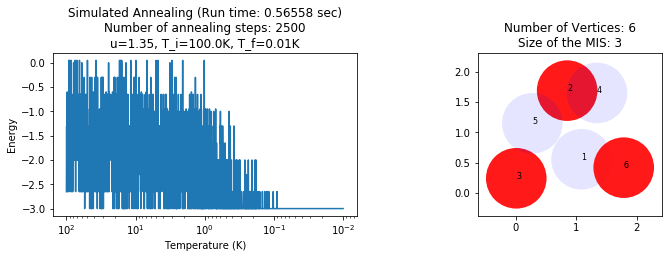

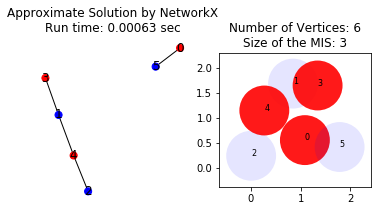

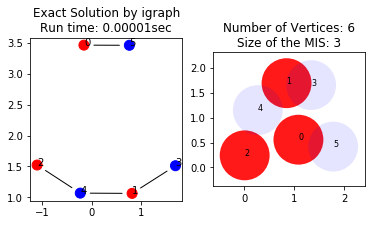

In [53]:
num_vertices = 6; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)
# plt.savefig("benchmark_6_vertices.png", dpi=300, bbox_inches="tight")


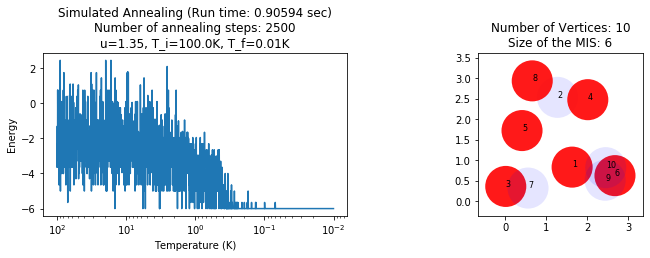

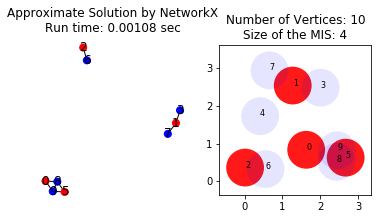

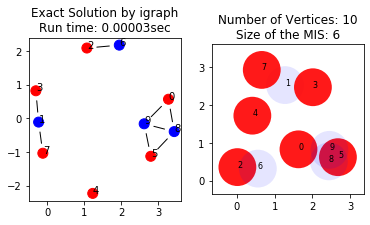

In [54]:
num_vertices = 10; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

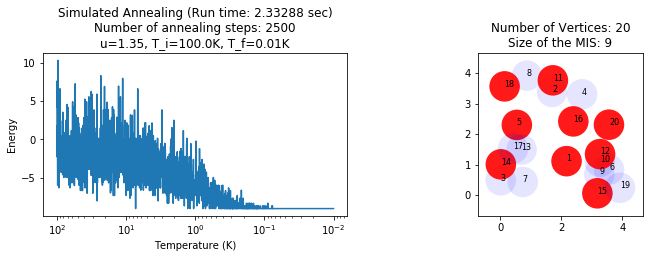

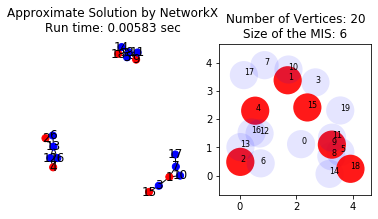

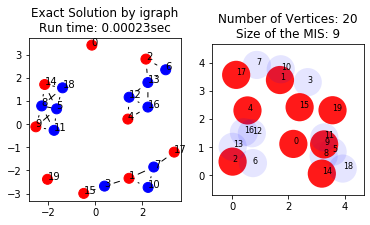

In [55]:
num_vertices = 20; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

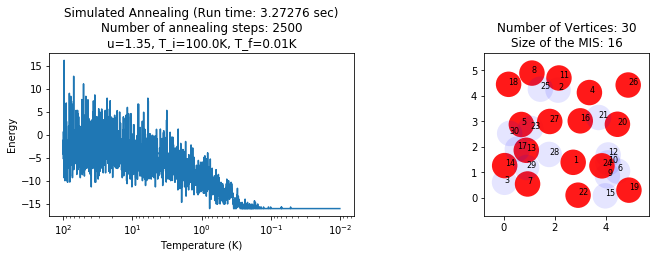

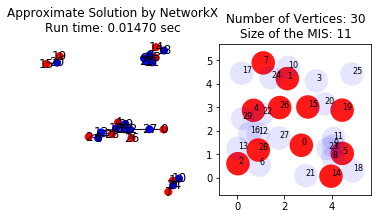

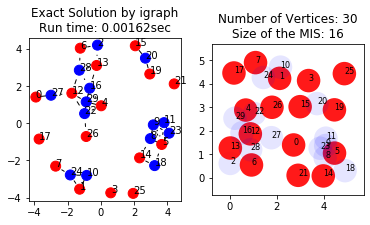

In [56]:
num_vertices = 30; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

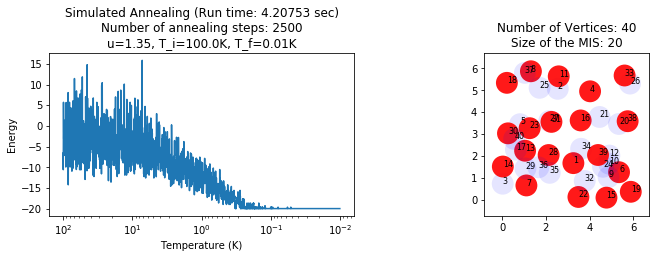

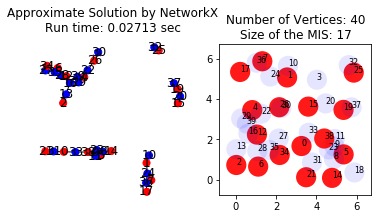

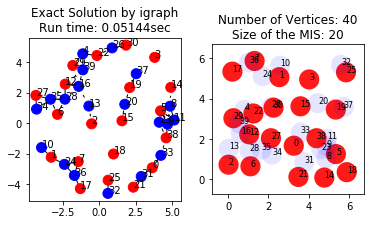

In [57]:
num_vertices = 40; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

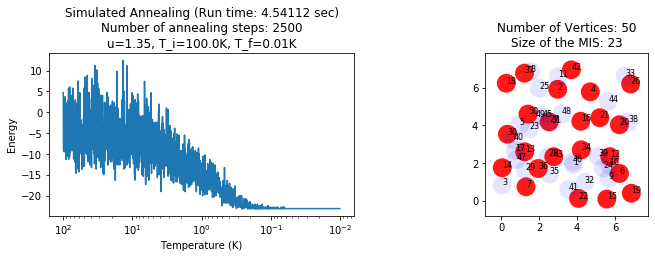

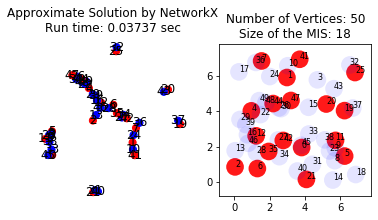

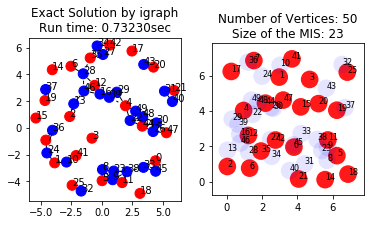

In [58]:
num_vertices = 50; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

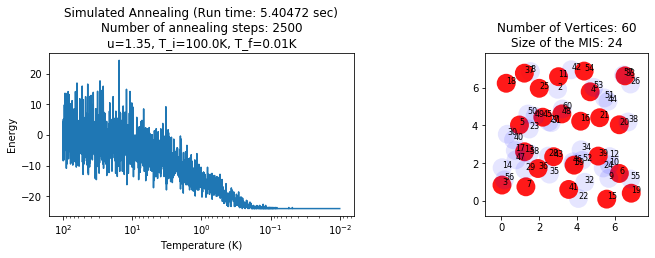

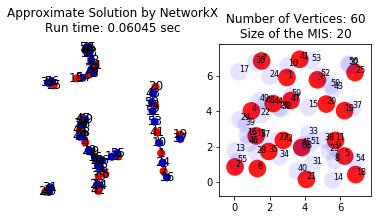

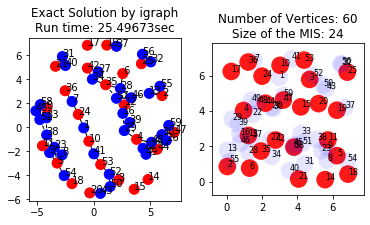

In [59]:
num_vertices = 60; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

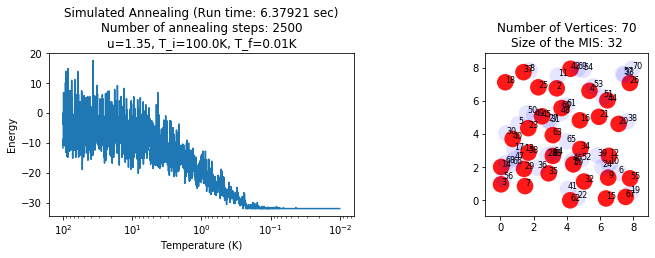

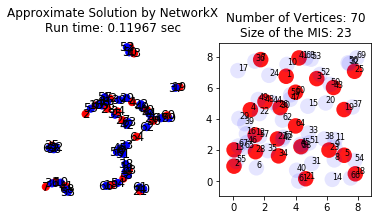

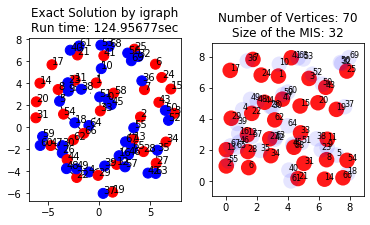

In [60]:
num_vertices = 70; num_vertices_list.append(num_vertices)
graph = []; graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

# Run simulated annealing
u=1.35; udmis = UDMIS(u, graph)
mis_size, run_time, temp_, E_ = run_annealing(udmis, N=2500, T_i=100, T_f=0.01, annotate=True);
run_time_annealing.append(run_time); mis_size_annealing.append(mis_size)

# Run NetworkX approximate solution
mis_size, run_time, mis = networkx_mis(graph, True);
run_time_networks.append(run_time); mis_size_networks.append(mis_size)

# Run iGraph exact solution
mis_size, run_time, mis = igraph_mis(graph, True);
run_time_igraph.append(run_time); mis_size_igraph.append(mis_size)

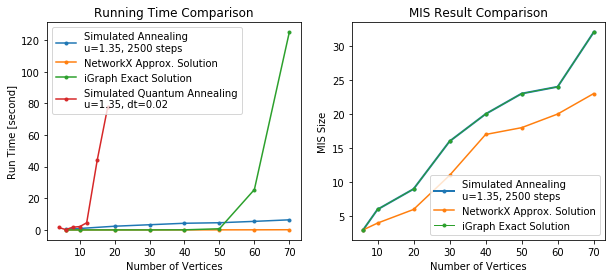

In [62]:
# Data from quantum annealing
num_vertices_q = [4,6,8,10,12,15,18]
run_times_q = [1.558, 0.198, 1.714, 2.099, 4.482, 43.887, 77.392]

fig=plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
ax1.plot(num_vertices_list, run_time_annealing,'.-',c='tab:blue', label = 'Simulated Annealing\nu=1.35, 2500 steps')
ax1.plot(num_vertices_list, run_time_networks,'.-',c='tab:orange', label = 'NetworkX Approx. Solution')
ax1.plot(num_vertices_list, run_time_igraph,'.-',c='tab:green', label = 'iGraph Exact Solution')
ax1.plot(num_vertices_q, run_times_q,'.-',c='tab:red', label = 'Simulated Quantum Annealing\nu=1.35, dt=0.02')


ax1.legend(loc='center left')
ax1.set_title('Running Time Comparison')
ax1.set_xlabel('Number of Vertices')
ax1.set_ylabel('Run Time [second]')
ax1.legend(loc='upper left')

# ax2 = ax1.twinx()
ax2= fig.add_subplot(122)
ax2.plot(num_vertices_list, mis_size_annealing,'.-', lw=2,c='tab:blue', label = 'Simulated Annealing\nu=1.35, 2500 steps')
ax2.plot(num_vertices_list, mis_size_networks,'.-', c='tab:orange', label = 'NetworkX Approx. Solution')
ax2.plot(num_vertices_list, mis_size_igraph,'.-',lw=1, c='tab:green', label = 'iGraph Exact Solution')
ax2.set_title('MIS Result Comparison')
ax2.set_xlabel('Number of Vertices')
ax2.set_ylabel('MIS Size')
ax2.legend(loc='lower right')
# plt.title('Simulated Annealing\nComputation Performance vs. Cooling Speed\n u={:0.2f}, T_i=100, T_f=0.01'.format(u))
plt.savefig('Benchmarking.png', dpi=300, bbox_inches='tight')
plt.show()

# Task 3

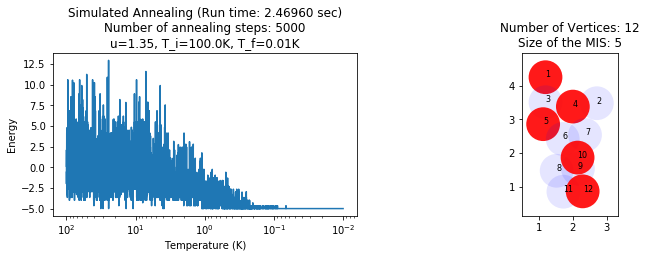

In [66]:
u = 1.35
gotham_city = [(1.19, 4.25), 
         (2.71, 3.48), 
         (1.19, 3.51), 
         (2,3.38), 
         (1.12, 2.86), 
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87),
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis, annotate=True);


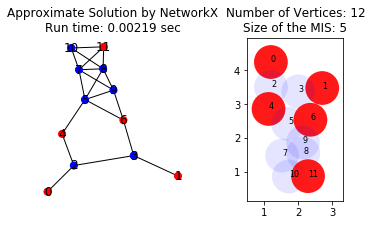

In [67]:
networkx_mis(graph, True);

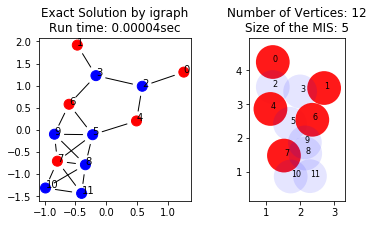

(5, 3.981590270996094e-05, (0, 1, 4, 6, 7))

In [68]:
igraph_mis(graph, True)

The solution is not unique. Let's get all the solution from the igraph exact algorithm.

In [69]:
edges = []
for i in range(len(graph)):
    for j in range(i+1, len(graph)):
        dij = np.sqrt((graph[i][0] - graph[j][0])**2 + (graph[i][1] - graph[j][1])**2)
        if dij<=1:
            edges.append((i,j))
    
g = igraph.Graph()
g.add_vertices(len(graph))
g.add_edges(edges)
all_MIS = g.largest_independent_vertex_sets()
print('Multiple solutions to the Gotham city problem:',all_MIS)

Multiple solutions to the Gotham city problem: [(0, 1, 4, 6, 7), (0, 1, 4, 6, 8), (0, 1, 4, 6, 10), (0, 1, 4, 6, 11), (0, 1, 4, 9, 10), (0, 1, 4, 9, 11), (0, 3, 4, 9, 10), (0, 3, 4, 9, 11)]
